In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from cuml import DBSCAN
from cuml.metrics.cluster import silhouette_score
import time
%matplotlib inline

In [14]:
df = pd.read_csv("enron_data_fraud_labeled.csv")
#drop class label
df=df.drop(['Label'],axis=1)
df.head()

/tmp/ipykernel_213614/1780134095.py:1: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("enron_data_fraud_labeled.csv")


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Attendees,Re,Source,Mail-ID,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,maildir,arnold-j,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,,Enron Data,b399fa1ba5ec06ccf8ead1049a53be981d0ebb39ee2c94...,False,False,External,18.0,False,False
1,maildir,arnold-j,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,84b07d7a0a17b545896f670f92d200e86843c2796147d9...,False,False,External,4.0,True,False
2,maildir,arnold-j,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,f7482dd06262f46d341e733aa0c2fb55cb1e257ea153d0...,False,False,External,3.0,True,False
3,maildir,arnold-j,<2526360.1075857584903.JavaMail.evans@thyme>,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,john.arnold@enron.com,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,25441e5a837fefda50527731fdbcdf0848663be82cd1ce...,False,False,External,9.0,False,True
4,maildir,arnold-j,<30102065.1075857630952.JavaMail.evans@thyme>,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,daily charts and matrices as hot links 5/15,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,c2995c6a70b953ee66c21d8a509ebfbfaca28277917beb...,False,False,External,352.0,False,False


In [15]:
df=df.drop(['Folder-User','Mime-Version','Message-ID','Date','From','To','Subject','X-From','X-cc','X-Folder','Body','Cc','Bcc','Re','Source','Mail-ID',
            'Suspicious-Folders'], axis=1)
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-bcc,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,arnold-j,text/plain; charset=ANSI_X3.4-1968,7bit,"""John Arnold"" <jarnold@enron.com>",NaN,Arnold-J,Jarnold.nsf,,,False,External,18.0,False,False
1,arnold-j,text/plain; charset=us-ascii,7bit,John.Arnold@enron.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,4.0,True,False
2,arnold-j,text/plain; charset=us-ascii,7bit,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",NaN,Arnold-J,Jarnold.nsf,,,False,External,3.0,True,False
3,arnold-j,text/plain; charset=us-ascii,7bit,john.arnold@enron.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,9.0,False,True
4,arnold-j,text/plain; charset=us-ascii,7bit,soblander@carrfut.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,352.0,False,False


In [16]:
df=df.drop(['X-bcc'], axis=1).dropna()
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,arnold-j,text/plain; charset=ANSI_X3.4-1968,7bit,"""John Arnold"" <jarnold@enron.com>",Arnold-J,Jarnold.nsf,,,False,External,18.0,False,False
1,arnold-j,text/plain; charset=us-ascii,7bit,John.Arnold@enron.com,Arnold-J,Jarnold.nsf,,,False,External,4.0,True,False
2,arnold-j,text/plain; charset=us-ascii,7bit,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",Arnold-J,Jarnold.nsf,,,False,External,3.0,True,False
3,arnold-j,text/plain; charset=us-ascii,7bit,john.arnold@enron.com,Arnold-J,Jarnold.nsf,,,False,External,9.0,False,True
4,arnold-j,text/plain; charset=us-ascii,7bit,soblander@carrfut.com,Arnold-J,Jarnold.nsf,,,False,External,352.0,False,False


In [17]:
le = LabelEncoder()
categorical = ['Folder-Name','Content-Type','Content-Transfer-Encoding','X-To','X-Origin','X-FileName','Time','Attendees','POI-Present','Sender-Type',
               'Low-Comm','Contains-Reply-Forwards']
for variable in categorical:
    df[variable] = le.fit_transform(df[variable])
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,1,1,1,2988,4,64,0,0,0,0,18.0,0,0
1,1,2,1,36621,4,64,0,0,0,0,4.0,1,0
2,1,2,1,10480,4,64,0,0,0,0,3.0,1,0
3,1,2,1,68130,4,64,0,0,0,0,9.0,0,1
4,1,2,1,71437,4,64,0,0,0,0,352.0,0,0


In [18]:
cols = df.columns
ms = MinMaxScaler()
df = ms.fit_transform(df)
df = pd.DataFrame(df, columns=[cols])
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,0.006849,0.5,0.333333,0.041302,0.015748,0.151659,0.0,0.0,0.0,0.0,0.003281,0.0,0.0
1,0.006849,1.0,0.333333,0.506192,0.015748,0.151659,0.0,0.0,0.0,0.0,0.000729,1.0,0.0
2,0.006849,1.0,0.333333,0.144859,0.015748,0.151659,0.0,0.0,0.0,0.0,0.000547,1.0,0.0
3,0.006849,1.0,0.333333,0.941724,0.015748,0.151659,0.0,0.0,0.0,0.0,0.001641,0.0,1.0
4,0.006849,1.0,0.333333,0.987435,0.015748,0.151659,0.0,0.0,0.0,0.0,0.064163,0.0,0.0


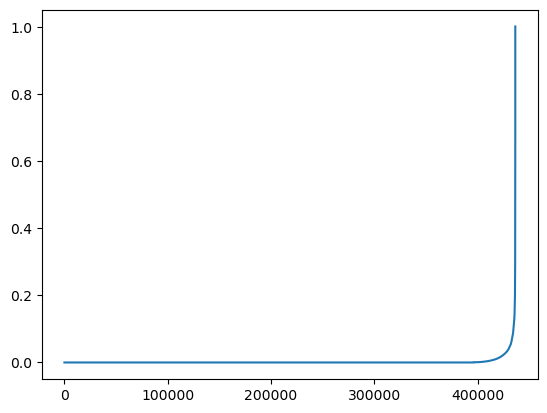

In [7]:
from cuml.neighbors import NearestNeighbors

#find a good range of epsilon using k=2*dim, then test
neighbors = NearestNeighbors(n_neighbors=26)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [7]:
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.02, stop=0.051, step=0.01)
min_sample_list=np.arange(start=14, stop=27, step=1)

# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(df)))>1):
            sil_score=silhouette_score(df, db.fit_predict(df), chunksize=30000)
        else:
            continue
        trial_parameters="eps:" + str(eps_trial) +" min_sample :" + str(min_sample_trial)
        
        silhouette_scores_data=pd.concat([silhouette_scores_data, pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"])])
        print("min_samples=%d done" % min_sample_trial)
    print("eps=%f done" % eps_trial)
 
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

min_samples=14 done
min_samples=15 done
min_samples=16 done
min_samples=17 done
min_samples=18 done
min_samples=19 done
min_samples=20 done
min_samples=21 done
min_samples=22 done
min_samples=23 done
min_samples=24 done
min_samples=25 done
min_samples=26 done
eps=0.020000 done
min_samples=14 done
min_samples=15 done
min_samples=16 done
min_samples=17 done
min_samples=18 done
min_samples=19 done
min_samples=20 done
min_samples=21 done
min_samples=22 done
min_samples=23 done
min_samples=24 done
min_samples=25 done
min_samples=26 done
eps=0.030000 done
min_samples=14 done
min_samples=15 done
min_samples=16 done
min_samples=17 done
min_samples=18 done
min_samples=19 done
min_samples=20 done
min_samples=21 done
min_samples=22 done
min_samples=23 done
min_samples=24 done
min_samples=25 done
min_samples=26 done
eps=0.040000 done
min_samples=14 done
min_samples=15 done
min_samples=16 done
min_samples=17 done
min_samples=18 done
min_samples=19 done
min_samples=20 done
min_samples=21 done
min_sa

,score,parameters
0,0.173855,eps:0.02 min_sample :14


In [19]:
db = DBSCAN(eps=0.02, min_samples=14)
start_time = time.time()
db.fit(df)
end_time = time.time()
end_time-start_time

94.40056276321411

In [9]:
no_clusters = len(np.unique(db.labels_))
no_noise = np.sum(np.array(db.labels_) == -1, axis=0)
if (no_clusters>2):
    no_clusters -= 1
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 4311
Estimated no. of noise points: 98396


In [10]:
db_label = pd.DataFrame(db.labels_, columns=['Cluster'])
df_new = pd.concat([df, db_label], axis=1)
df_new = df_new.loc[df_new['Cluster']!=-1]
df_new .info()

<class 'pandas.core.frame.DataFrame'>
Index: 338175 entries, 0 to 436570
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   (Folder-Name,)                338175 non-null  float64
 1   (Content-Type,)               338175 non-null  float64
 2   (Content-Transfer-Encoding,)  338175 non-null  float64
 3   (X-To,)                       338175 non-null  float64
 4   (X-Origin,)                   338175 non-null  float64
 5   (X-FileName,)                 338175 non-null  float64
 6   (Time,)                       338175 non-null  float64
 7   (Attendees,)                  338175 non-null  float64
 8   (POI-Present,)                338175 non-null  float64
 9   (Sender-Type,)                338175 non-null  float64
 10  (Unique-Mails-From-Sender,)   338175 non-null  float64
 11  (Low-Comm,)                   338175 non-null  float64
 12  (Contains-Reply-Forwards,)    338175 non-null  fl

In [12]:
#silhouette score after removing noise
df_cluster = df_new['Cluster']
df2 = df_new.drop('Cluster', axis=1)
silhouette_score(df2, df_cluster, chunksize=30000)

0.48705646104672756